<a href="https://colab.research.google.com/github/Chiosas/Cats_for_GAN/blob/master/Adversarial_and_Style_Transfer_images_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ***Environment setup***

In [0]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import IPython.display as display
# import PIL.Image
import time

import tensorflow_hub as hub

mpl.rcParams['figure.figsize'] = (16, 8)
mpl.rcParams['axes.grid'] = False

In [0]:
tf.__version__

'2.1.0-rc1'

## ***Adversarial example***

In [0]:
pretrained_model = tf.keras.applications.Xception(include_top=True, weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.xception.decode_predictions

In [0]:
# Helper function to preprocess the image so that it can be inputted in InceptionV3
def preprocess(image, image_dims):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.image.central_crop(image, central_fraction=1)
    image = tf.image.resize(image, image_dims)
    image = image[None, ...]
    return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
    return decode_predictions(probs, top=1)[0][0]

### ***Original image***

In [0]:
image_path = tf.keras.utils.get_file(
    fname='Lion-Cubs.jpg',
    origin='https://planetexoticpets.com/wp-content/uploads/2019/03/Lion-Cubs.jpg'
    )
image_raw = tf.io.read_file(image_path)
image_raw = tf.image.decode_image(image_raw)

IMG_DIMS = (299, 299)

image = preprocess(image_raw, IMG_DIMS)
image_probs = pretrained_model.predict(image)

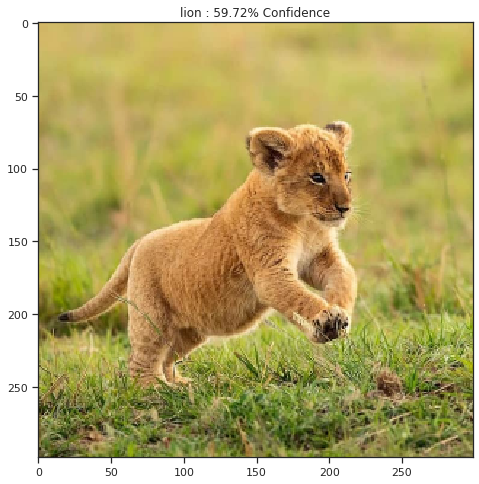

In [0]:
sns.set(style='ticks')
plt.figure()
plt.imshow(image[0])
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title(f'{image_class} : {class_confidence*100:.2f}% Confidence')
plt.show()

### ***Adversarial image***

In [0]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = pretrained_model(input_image)
        loss = loss_object(input_label, prediction)

    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, input_image)
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    return signed_grad

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


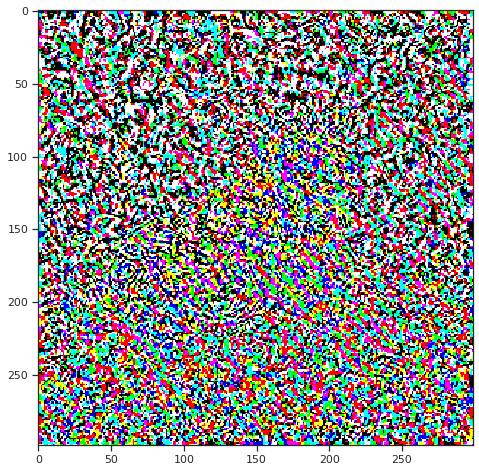

In [0]:
# Get the input label of the image.
# https://gist.github.com/maraoz/388eddec39d60c6d52d4#file-gistfile1-txt
label_index = 291
label = tf.one_hot(label_index, image_probs.shape[-1])

perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0])

In [0]:
def display_images(image, description):
    _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
    plt.figure()
    plt.imshow(image[0])
    plt.title(f'{description} \n {label} : {confidence * 100:.2f}% Confidence')
    plt.show()

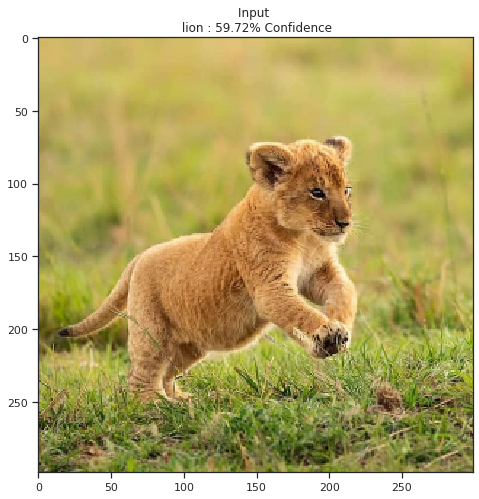

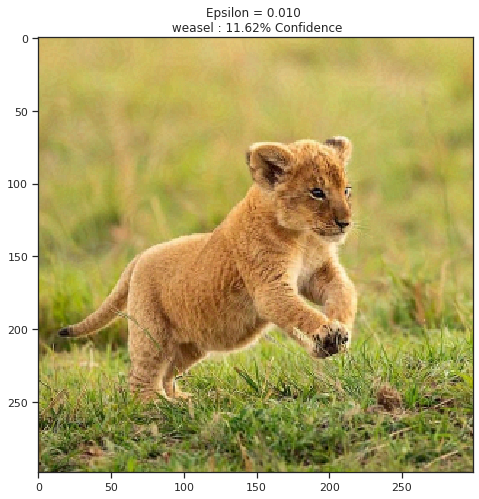

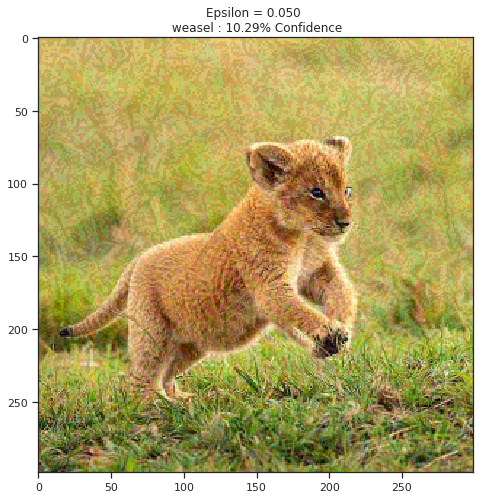

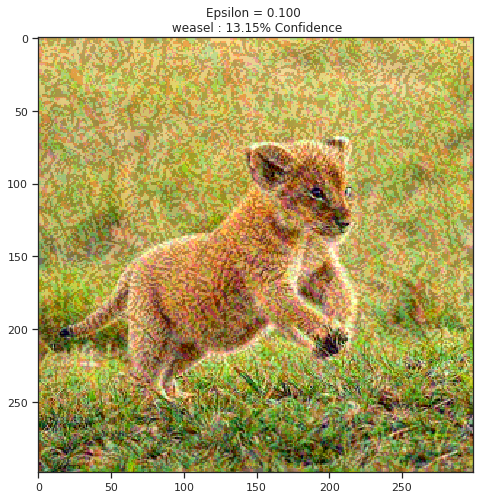

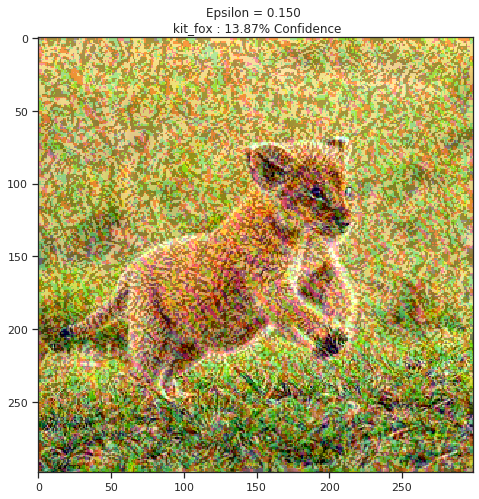

In [0]:
epsilons = [0, 0.01, 0.05, 0.1, 0.15]
descriptions = [(f'Epsilon = {eps:0.3f}' if eps else 'Input') for eps in epsilons]

for i, eps in enumerate(epsilons):
    adv_img = image + eps * perturbations
    adv_img = tf.clip_by_value(adv_img, 0, 1)
    display_images(adv_img, descriptions[i])

## ***Neural style transfer***

### ***Style image***

In [0]:
style_path = tf.keras.utils.get_file(
    fname='p297778_2a_400.jpg',
    origin='https://images1.novica.net/pictures/10/p297778_2a_400.jpg'
)

In [0]:
def load_img(path_to_image):
    max_dim = 512
    image = tf.io.read_file(path_to_image)
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)

    shape = tf.cast(tf.shape(image)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    image = tf.image.resize(image, new_shape)
    image = image[tf.newaxis, :]
    return image

In [0]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)
        
    plt.show()

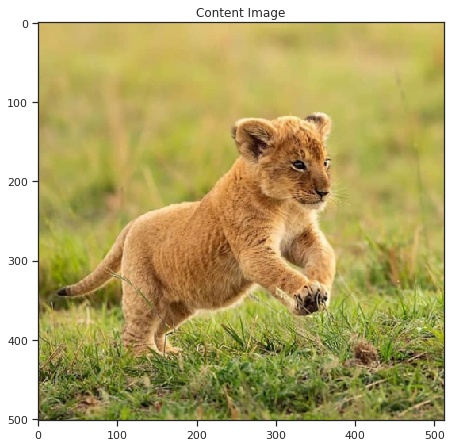

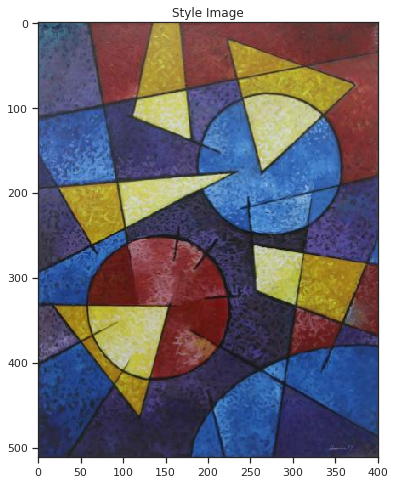

In [0]:
content_image = load_img(image_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

### ***Style Transfer with TF Hub***

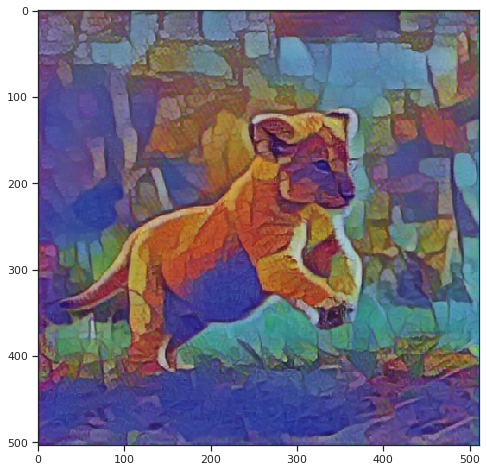

In [0]:
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]
imshow(stylized_image)

### ***Manual style transfer***

In [0]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

for layer in vgg.layers:
    print(layer.name)

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [0]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer of interest
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [0]:
def vgg_layers(layer_names):
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
  
    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [0]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / (num_locations)

In [0]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        # Expects float input in [0,1]
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (
            outputs[:self.num_style_layers], 
            outputs[self.num_style_layers:]
        )

        style_outputs = [gram_matrix(style_output)
                        for style_output in style_outputs]

        content_dict = {content_name:value 
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}
    
        return {'content':content_dict, 'style':style_dict}

In [0]:
extractor = StyleContentModel(style_layers, content_layers)

style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [0]:
generated_image = tf.Variable(content_image)

In [0]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [0]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [0]:
style_weight = 1e-2
content_weight = 1000
total_variation_weight = 30

In [0]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name]) ** 2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [0]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight * tf.image.total_variation(image)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

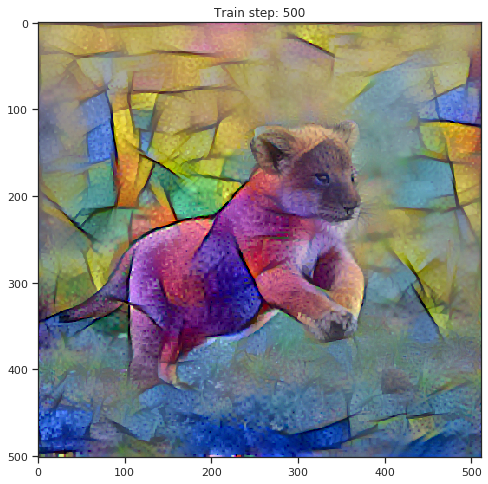

None

Train step: 500
Total time: 2880.4


In [0]:
start = time.time()

epochs = 20
steps_per_epoch = 25

step = 0
for n in range(epochs):
    display.clear_output(wait=True)
    display.display(imshow(generated_image, f'Train step: {step}'))
    print(f'Train step: {step}')
    for m in range(steps_per_epoch):
        step += 1
        train_step(generated_image)
        print('.', end='')
  
end = time.time()

display.clear_output(wait=True)
display.display(imshow(generated_image, f'Train step: {step}'))
print(f'Train step: {step}')
print(f'Total time: {end-start:.1f}')

## ***The End***

In [0]:
# Check the examples on the web:
# Article - https://sefiks.com/2018/07/20/artistic-style-transfer-with-deep-learning/
# Code - https://github.com/serengil/tensorflow-101/blob/master/python/style-transfer.ipynb